## Coin Segmentation
using watershed and region props

**scikit-image**: segmentation and regionprops


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

skimage.__version__

'0.15.0'

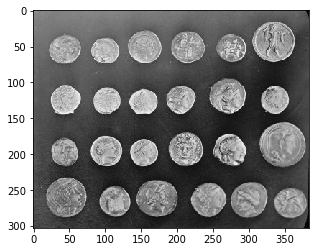

In [2]:
from skimage import data
coins = data.coins()
plt.imshow(coins, cmap='gray')

**Denoise image**

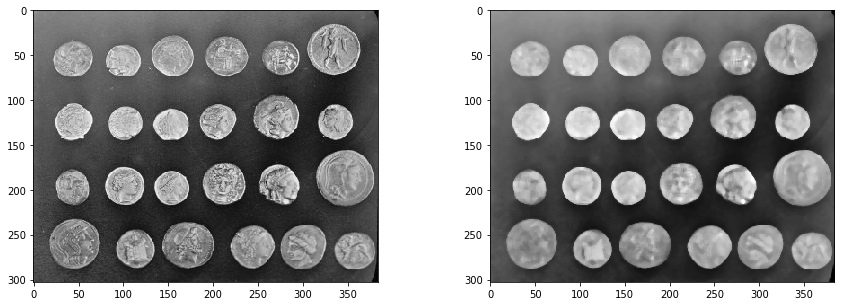

In [3]:
from skimage import filters

coins_denoised = filters.median(coins, selem=np.ones((5,5)))
f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(coins, cmap='gray')
ax1.imshow(coins_denoised, cmap='gray')

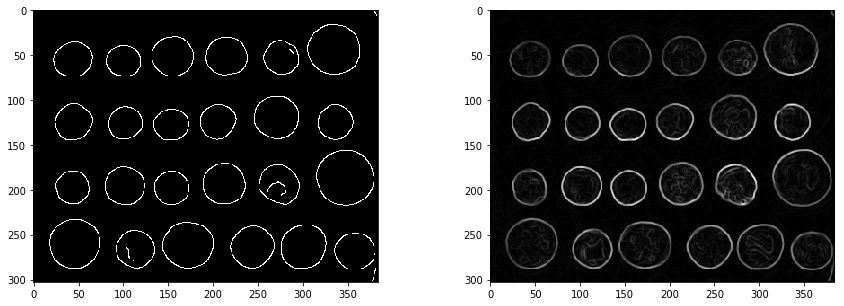

In [4]:
from skimage import feature, filters

edges = skimage.feature.canny(coins_denoised/255, sigma=3)
sobel_edges = skimage.filters.sobel(coins_denoised)

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(edges, cmap='gray')
ax1.imshow(sobel_edges, cmap='gray')

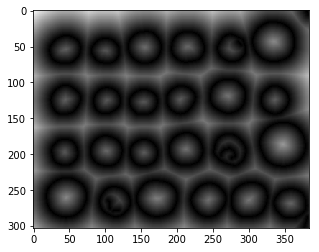

In [5]:
from scipy.ndimage import distance_transform_edt # euclidian distance - distance to closest background pixel 
dt = distance_transform_edt(~edges)              # call on negative of edges
plt.imshow(dt, cmap='gray')

**Watershed algorithm**

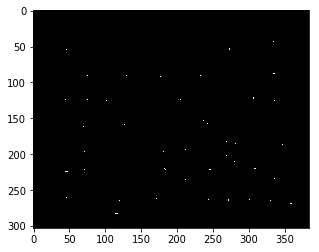

In [6]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=5)
plt.imshow(local_max, cmap='gray')

In [7]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=5)
peak_idx[:5]

array([[283, 115],
       [283, 114],
       [282, 117],
       [282, 116],
       [282, 115]])

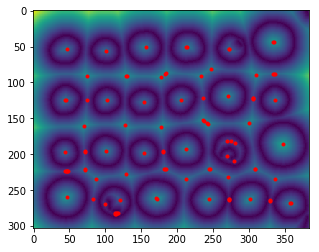

In [8]:
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
plt.imshow(dt)

In [0]:
from skimage import measure

markers = measure.label(local_max)

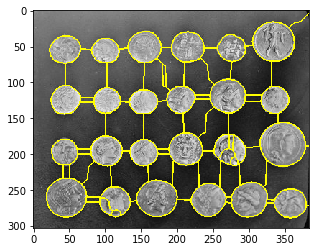

In [10]:
from skimage import morphology, segmentation

labels = morphology.watershed(-dt, markers)     # center of coin becomes trough
plt.imshow(segmentation.mark_boundaries(coins, labels))

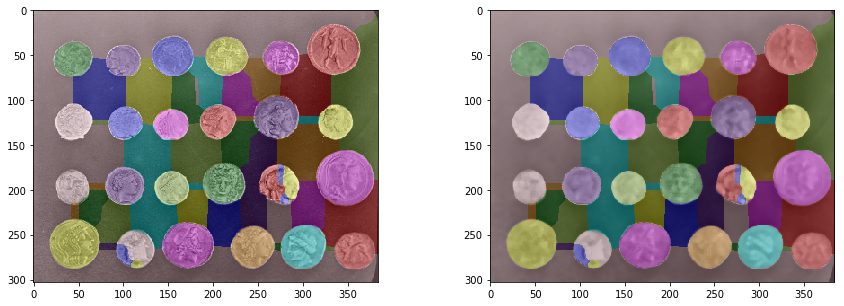

In [11]:
from skimage import color

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(color.label2rgb(labels, image=coins))
ax1.imshow(color.label2rgb(labels, image=coins_denoised))

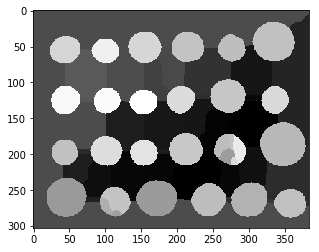

In [12]:
plt.imshow(color.label2rgb(labels, image=coins, kind='avg'), cmap='gray')

In [0]:
regions = measure.regionprops(labels, intensity_image=coins)      # list of region properties

(array([8., 5., 6., 5., 2., 3., 3., 1., 0., 0., 0., 0., 4., 2., 4., 8., 3.,
        4., 2., 3.]),
 array([ 34.53677621,  42.59112696,  50.6454777 ,  58.69982845,
         66.75417919,  74.80852994,  82.86288068,  90.91723142,
         98.97158217, 107.02593291, 115.08028366, 123.1346344 ,
        131.18898515, 139.24333589, 147.29768664, 155.35203738,
        163.40638812, 171.46073887, 179.51508961, 187.56944036,
        195.6237911 ]),
 <a list of 20 Patch objects>)

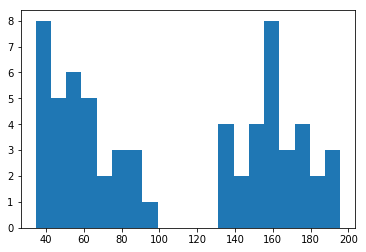

In [14]:
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20, label='Mean intensity of objects assoc. with background and coins') 

In [0]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)

region_means = np.array(region_means).reshape(-1,1)

In [16]:
region_means

array([[156.8396339 ],
       [169.91215786],
       [157.83575198],
       [154.67418773],
       [168.45105717],
       [185.1305638 ],
       [ 66.89524517],
       [ 80.47629468],
       [ 81.20661157],
       [ 57.3572903 ],
       [ 48.36122525],
       [ 91.61489362],
       [ 83.73325809],
       [ 66.57707254],
       [ 75.11176906],
       [159.58114035],
       [ 63.128     ],
       [ 40.46116505],
       [190.824     ],
       [ 89.64912281],
       [172.82133565],
       [192.9032882 ],
       [171.25219684],
       [195.6237911 ],
       [ 48.47252747],
       [ 37.38604353],
       [ 35.76727786],
       [ 53.87255294],
       [ 82.9031754 ],
       [ 49.60990712],
       [153.33920705],
       [157.83185841],
       [182.89791667],
       [150.73552632],
       [160.21518987],
       [173.4888424 ],
       [ 61.36842105],
       [ 52.54385965],
       [156.27184466],
       [178.13752277],
       [133.75862069],
       [172.35416667],
       [ 38.51346655],
       [ 45

In [17]:
model.fit(region_means)
print(model.cluster_centers_)

[[ 57.57802446]
 [161.66761429]]


In [18]:
bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1],
      dtype=int32)

In [0]:
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
  classified_labels[tuple(region.coords.T)] = bg_fg

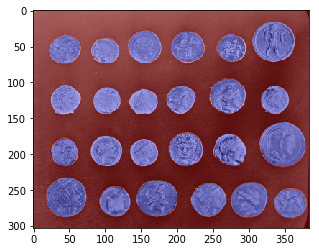

In [20]:
plt.imshow(color.label2rgb(classified_labels, image=coins))